In [1]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [41]:
def scale_sobel(sobel_in):
    return np.uint8(255*sobel_in/np.max(sobel_in))

def combined_thresh_color(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    luv = cv2.cvtColor(img,cv2.COLOR_BGR2LUV).astype(np.float)
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB).astype(np.float)
    
    hls_s_thresh=(120,255)
    hls_s_channel = hls[:,:,2]
    
    luv_l_thresh=(220,255)
    luv_l_channel = luv[:,:,0]
    
    luv_v_thresh=(170,255)
    luv_v_channel = luv[:,:,2]
    
    lab_l_thresh=(205,255)
    lab_l_channel = lab[:,:,0]
    
    lab_b_thresh=(145,255)
    lab_b_channel = lab[:,:,2]
    
    
    # Threshold color channel
    hls_s_binary = np.zeros_like(hls_s_channel)
    hls_s_binary[(hls_s_channel >= hls_s_thresh[0]) & (hls_s_channel <= hls_s_thresh[1])] = 1
    
    luv_l_binary = np.zeros_like(luv_l_channel)
    luv_l_binary[(luv_l_channel >= luv_l_thresh[0]) & (luv_l_channel <= luv_l_thresh[1])] = 1
    
    luv_v_binary = np.zeros_like(luv_l_channel)
    luv_v_binary[(luv_v_channel >= luv_v_thresh[0]) & (luv_v_channel <= luv_v_thresh[1])] = 1
    
    lab_l_binary = np.zeros_like(lab_l_channel)
    lab_l_binary[(lab_l_channel >= lab_l_thresh[0]) & (lab_b_channel <= lab_l_thresh[1])] = 1
    
    lab_b_binary = np.zeros_like(lab_b_channel)
    lab_b_binary[(lab_b_channel >= lab_b_thresh[0]) & (lab_b_channel <= lab_b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(hls_s_binary)
    combined_binary[( (luv_l_binary > 0) | (luv_v_binary > 0) | (lab_l_binary > 0) | (lab_b_binary > 0) ) & (hls_s_binary > 0 )] = 1  

    return combined_binary

def combined_thresh_gradient(img, sobel_kernel=3, sobel_thresh=(0,255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), s_thresh=(0,255)):

    sobel_kernel=3
    sobel_thresh=(10,255)
    mag_thresh=(30,100)
    dir_thresh=(np.pi/6, np.pi/2)
    s_thresh=(100,255)
    l_thresh=(120, 255)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_abs_x=np.absolute(sobelx)
    sobel_abs_y=np.absolute(sobely)

    scaled_sobel_x = scale_sobel(sobel_abs_x)
    scaled_sobel_y = scale_sobel(sobel_abs_y)

    gradx = np.zeros_like(scaled_sobel_x)
    grady = np.zeros_like(scaled_sobel_y)
    gradx[(scaled_sobel_x >= sobel_thresh[0]) & (scaled_sobel_x <= sobel_thresh[1])] = 1
    grady[(scaled_sobel_y >= sobel_thresh[0]) & (scaled_sobel_y <= sobel_thresh[1])] = 1

    #mag thresh
    mag_absSobelxy=np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_mag_sobel=scale_sobel(mag_absSobelxy)

    mag_binary = np.zeros_like(scaled_mag_sobel)
    mag_binary[(scaled_mag_sobel >= mag_thresh[0]) & (scaled_mag_sobel <= mag_thresh[1])] = 1

    # dir_thresh
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 50
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]

    r_g_binary = np.zeros_like(R_channel)
    r_g_binary[(R_channel >= color_threshold) & (G_channel >= color_threshold)] = 1
    combined_condition = np.zeros_like(R_channel)
    combined_condition[ (gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) ] = 1

    combined = np.zeros_like(R_channel)
    combined[ ((r_g_binary==1) & (l_binary==1)) &
              ((s_binary == 1) | (combined_condition==1)) ] = 1

    # combine all four thresholds:

    #combined = np.zeros_like(dir_binary)
    #combined[(gradx == 1) |
    #         ((mag_binary == 1) & (dir_binary == 1) ) |
    #         (s_binary == 1) ] = 1

    return combined

(-0.5, 1279.5, 719.5, -0.5)

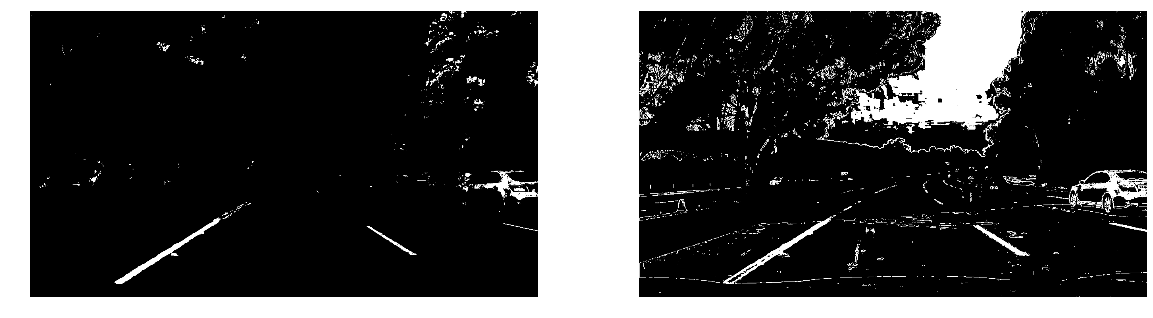

In [42]:
import glob

fname = 'test_images/test5.jpg'

plt.figure(figsize=(20,50))

test_img = cv2.imread(fname)
out1 = combined_thresh_color(test_img)
plt.subplot(2,2,1)
plt.imshow(out1,cmap='gray')
plt.axis('off')

out2 = combined_thresh_gradient(test_img,sobel_kernel=3,
                          sobel_thresh=(20,100),
                          mag_thresh=(30,100),
                          dir_thresh=(np.pi/6, np.pi/2),
                          s_thresh=(170,255))
plt.subplot(2,2,2)
plt.imshow(out2,cmap='gray')
plt.axis('off')

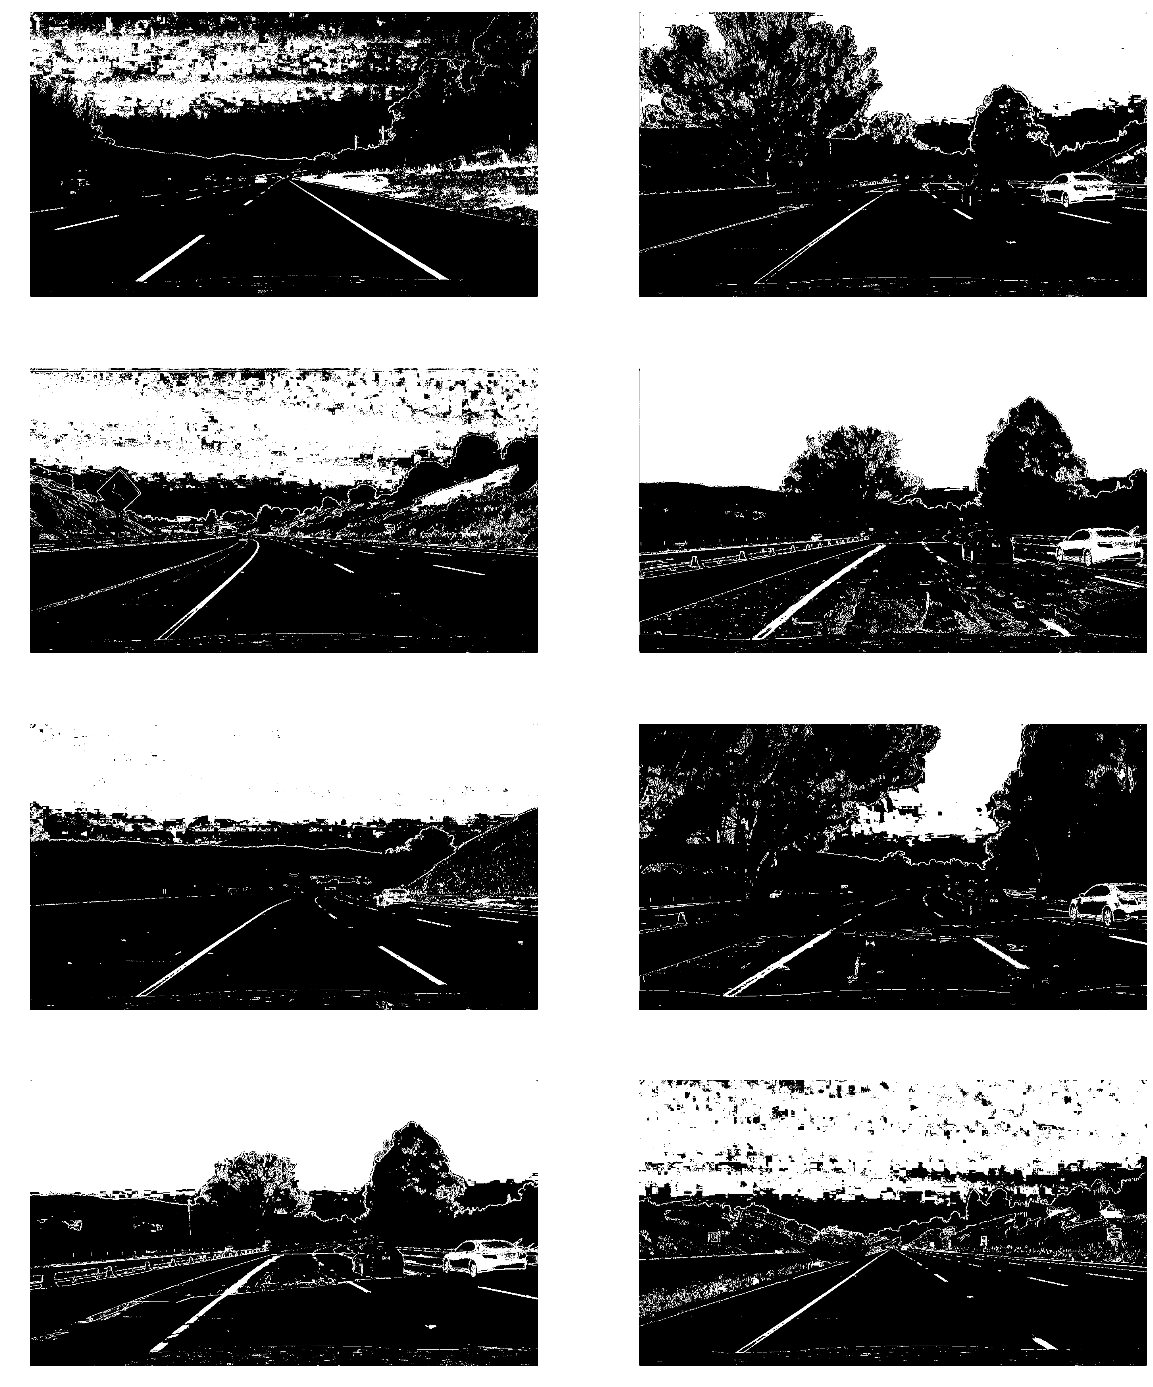

In [43]:
test_images=glob.glob('test_images/*.jpg')
num_images=len(test_images)
plt.figure(figsize=(20,50))
c=1

for fname in test_images:
    test_img = cv2.imread(fname)
    
    out = combined_thresh_gradient(test_img)

    plt.subplot(num_images,2,c)
    c+=1
    plt.imshow(out,cmap='gray')
    plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

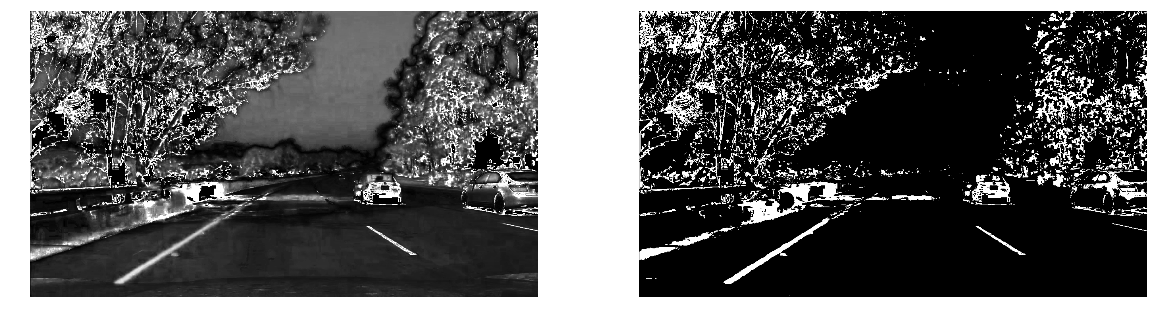

In [94]:
hls = cv2.cvtColor(test_img, cv2.COLOR_BGR2HLS).astype(np.float)

hls_s_thresh=(120,255)
hls_s_channel = hls[:,:,2]

hls_s_binary = np.zeros_like(hls_s_channel)
hls_s_binary[(hls_s_channel >= hls_s_thresh[0]) & (hls_s_channel <= hls_s_thresh[1])] = 1

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.imshow(hls_s_channel,cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(hls_s_binary,cmap='gray')
plt.axis('off')


(-0.5, 1279.5, 719.5, -0.5)

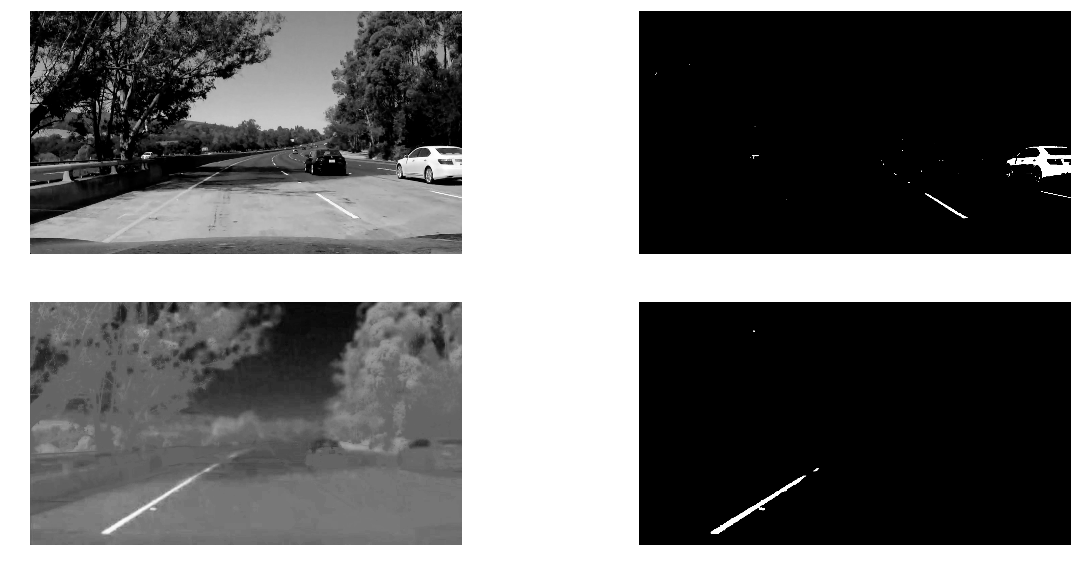

In [99]:
luv = cv2.cvtColor(test_img, cv2.COLOR_BGR2LUV).astype(np.float)

luv_l_channel = luv[:,:,0]
luv_v_channel = luv[:,:,2]

luv_l_binary = np.zeros_like(luv[:,:,0])
luv_l_binary[(luv_l_channel >= 220) & (luv_l_channel <= 255)] = 1

luv_v_binary = np.zeros_like(luv[:,:,2])
luv_v_binary[(luv_v_channel >= 170) & (luv_v_channel <= 255)] = 1

plt.figure(figsize=(20,20))

plt.subplot(4,2,1)
plt.imshow(luv_l_channel,cmap='gray')
plt.axis('off')

plt.subplot(4,2,2)
plt.imshow(luv_l_binary,cmap='gray')
plt.axis('off')

plt.subplot(4,2,3)
plt.imshow(luv_v_channel,cmap='gray')
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(luv_v_binary,cmap='gray')
plt.axis('off')



(-0.5, 1279.5, 719.5, -0.5)

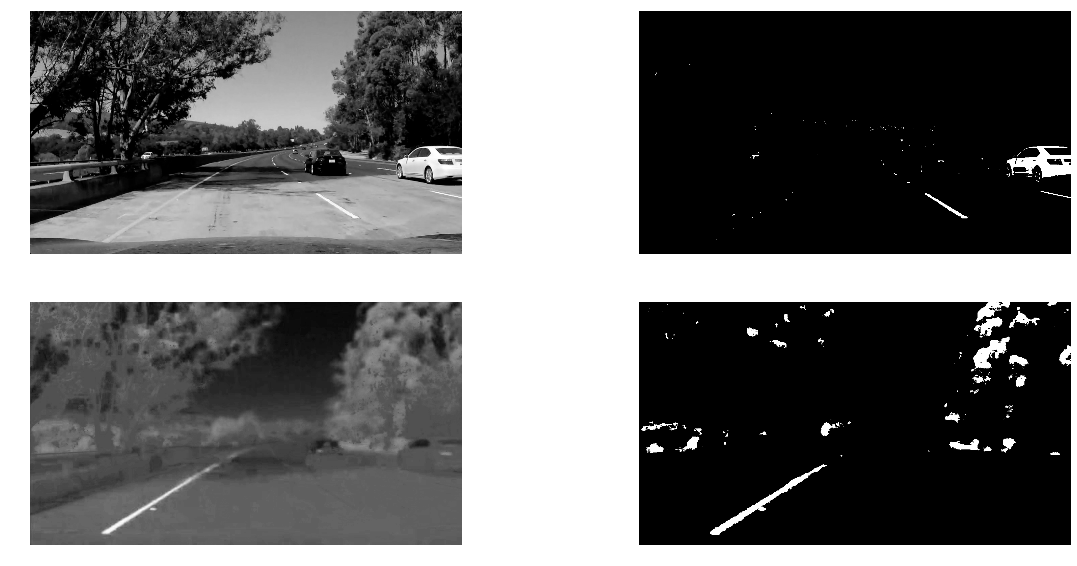

In [101]:
lab = cv2.cvtColor(test_img, cv2.COLOR_BGR2LAB).astype(np.float)

lab_b_channel = lab[:,:,2]
lab_l_channel = lab[:,:,0]

lab_l_binary = np.zeros_like(lab[:,:,0])
lab_l_binary[(lab_l_channel >= 205) & (lab_b_channel <= 255)] = 1

lab_b_binary = np.zeros_like(lab[:,:,2])
lab_b_binary[(lab_b_channel >= 145) & (lab_b_channel <= 255)] = 1

plt.figure(figsize=(20,20))

plt.subplot(4,2,1)
plt.imshow(lab_l_channel,cmap='gray')
plt.axis('off')

plt.subplot(4,2,2)
plt.imshow(lab_l_binary,cmap='gray')
plt.axis('off')

plt.subplot(4,2,3)
plt.imshow(lab_b_channel,cmap='gray')
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(lab_b_binary,cmap='gray')
plt.axis('off')
